#### Import de bibliotecas principais

In [13]:
import torch
import torch.nn as nn
import numpy as np
import os
import numpy as np
import torch
import pickle
from PIL import Image
import glob
#from vision.references.detection import transforms as T   # torchvision.transforms as T
from torchvision import datasets, transforms
from PIL import ImageFilter
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.svm import LinearSVC
import seaborn as sns
import matplotlib.pyplot as plt

## Load de dataset

In [2]:
# Transformação para tensor, resize
# crop e normalização das imagens
def get_transform():
    transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform

# Obtém o dataloader a partir de uma pasta
# Para testar o método, inicialmente treinei com duas classes, apenas. 
# Infelizmente, não tive tempo de otimizar o método para
# prosseguir com as demais classes
dataset = datasets.ImageFolder(
    root='dataset/temp/',
    transform=get_transform()
)

In [3]:
from torch.utils.data import Dataset, DataLoader
#from vision.references.detection import utils # as T
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


def train_val_dataset(dataset, val_split=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

#dataset = SpeedDataset(addrs_flow, labels, get_transform())
#dataset = SpeedDataset(addrs_rgb, addrs_flow, addrs_depth, labels, ids, get_transform())
datasets = train_val_dataset(dataset)

data_loader_train = DataLoader(datasets['train'], batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
data_loader_test = DataLoader(datasets['val'], batch_size=1, shuffle=True, num_workers=4, pin_memory=True) #

### Montagem do modelo

In [4]:
# Obtém VGG 16 pretreinada do ImageNet
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

# Obtém somente a camada de encoding
new_model = model.features 
new_model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [86]:
y_test = []

for i, (flow_stack, speed_vector) in enumerate(data_loader_val):
    y_test.append(speed_vector)

# Extração de features usando VGG 16

In [5]:
device = torch.device('cuda')
model = new_model.to(device)

# Para cada imagem do data loader,
# obtém as features correspondentes
_data=[]
_label=[]
for i, (data, label) in enumerate(data_loader_train):
    data, label = data.to(device), label.to(device)
    pred_speed = model(data)
    _data.append(list(pred_speed.reshape([1, 25088]).cpu().detach().numpy()[0]))
    _label.append(label.cpu().detach().numpy()[0])

In [7]:
device = torch.device('cuda')
model = new_model.to(device)

# Para cada imagem do data loader,
# obtém as features correspondentes
_data_test=[]
_label_test=[]
for i, (data, label) in enumerate(data_loader_test):
    data, label = data.to(device), label.to(device)
    pred_speed = model(data)
    _data_test.append(list(pred_speed.reshape([1, 25088]).cpu().detach().numpy()[0]))
    _label_test.append(label.cpu().detach().numpy()[0])

# Treinamento SVM

In [8]:
clf=LinearSVC(max_iter=10000)
clf.fit(_data,_label)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [9]:
predictions_svm = clf.predict(_data_test)

### Precisao

In [10]:
acc_svm = accuracy_score(_label_test, predictions_svm)
acc_svm

0.9733905579399141

### Matriz de confusão

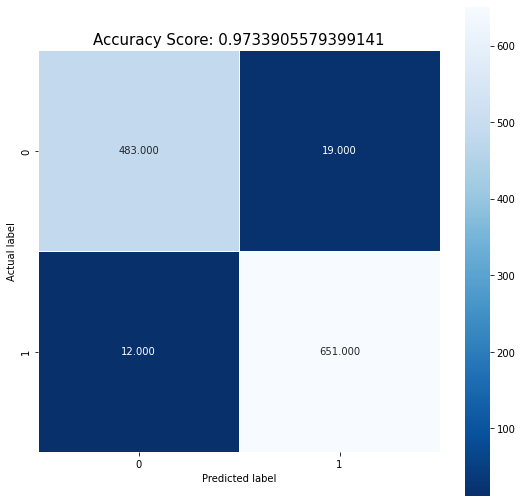

In [14]:
cm = confusion_matrix(_label_test, predictions_svm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_svm)
plt.title(all_sample_title, size = 15);

#### F1 Score

In [16]:
from sklearn.metrics import f1_score

score = f1_score(_label_test, predictions_svm, average="macro")
score

0.9728254531034966

### Precision Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve

# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

# Treinamento KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(_data, np.array(_label))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [18]:
predictions_knn = model.predict(_data_test)

### Precisao

In [19]:
acc_knn = accuracy_score(_label_test, predictions_knn)
acc_knn

0.8626609442060086

### Matriz de confusão

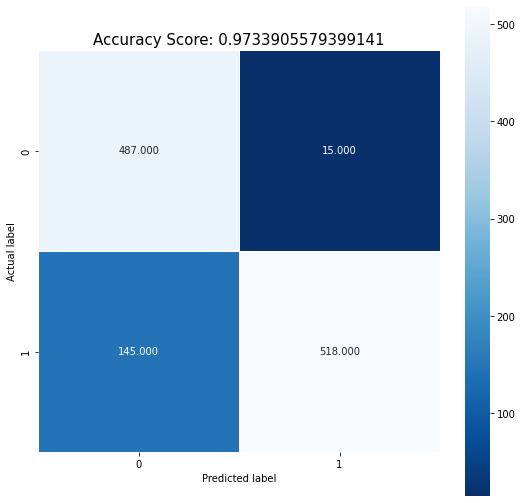

In [21]:
cm = confusion_matrix(_label_test, predictions_knn)

import seaborn as sns

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_svm)
plt.title(all_sample_title, size = 15);

#### F1 Score

In [23]:
from sklearn.metrics import f1_score

score = f1_score(_label_test, predictions_knn, average="macro")
score

0.8625636306795728

### Precision Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve

# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

# Treinamento Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
logisticRegr.fit(_data, np.array(_label))

In [ ]:
predictions_lr = model.predict(_data_test)

### Precisao

In [87]:
acc = accuracy_score(new_y_test, predictions_lr)
acc

0.9841836734693877

### Matriz de confusão

In [ ]:
cm = confusion_matrix(y_test, predictions_svm)

import seaborn as sns

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_svm)
plt.title(all_sample_title, size = 15);

#### F1 Score

In [ ]:
from sklearn.metrics import f1_score

score = f1_score(true_labels, pred_labels, average="macro")

### Precision Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve

# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()